In [1]:
# Sitting up the environnement
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold, learning_curve, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc

from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

Loading the data

In [2]:
recipe_site_traffic = pd.read_csv("recipe_site_traffic.csv", )
recipe_site_traffic.sample(10)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
615,616,45.02,8.83,0.80,3.57,Breakfast,1,NaN
597,598,212.40,19.20,2.25,23.78,Breakfast,2,NaN
636,637,2029.33,25.08,0.61,54.00,One Dish Meal,1,High
399,400,71.87,31.44,1.34,32.45,Chicken Breast,2,NaN
793,794,633.17,20.00,2.35,26.11,Lunch/Snacks,4,High
395,396,90.95,15.03,5.32,19.29,Breakfast,1,High
719,720,425.75,162.11,0.64,7.73,Lunch/Snacks,6,High
292,293,1878.82,0.80,7.60,89.01,Chicken Breast,1,High
214,215,299.32,9.58,2.50,125.50,Chicken,6,High
498,499,470.68,2.71,3.92,31.40,Breakfast,1,NaN


Data info

In [3]:
recipe_site_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


First things first, we can see that there is some data missing in calories, carbohydrate, sugar, protein and high_traffic columns. Second, category, servings and high_traffic columns are pandas objects (categorical).
According to the product manager 'servings' must be numerical so let's do the conversion.

### <span style="color:green"><b> Data Preprocessing</b></span>

Because we only have some columns to process, i'll be cleaning data column by column.

#### Dealing with "servings" data

Converting servings to integers as required

In [4]:
recipe_site_traffic['servings'].unique()

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

As we can see, there are some elements in the servings column that must be processed in the form of {integer+"as a snack"}.

In [5]:
recipe_site_traffic['servings'] = pd.to_numeric(recipe_site_traffic['servings'].str.split().str[0], errors='coerce')

Let's check if the column's data type has changed to numerical (integer)

In [6]:
recipe_site_traffic['servings'].dtype

dtype('int64')

In [7]:
recipe_site_traffic['servings'].unique()

array([6, 4, 1, 2])

Okay we have the right servings, moving on..

#### Dealing with "category" data

What categories do we have ?

In [8]:
category_list = list(recipe_site_traffic['category'].unique())
print(category_list, "\nN°categories =",len(category_list))

['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal', 'Chicken Breast', 'Lunch/Snacks', 'Chicken', 'Vegetable', 'Meat', 'Dessert'] 
N°categories = 11


Comparing with the list provided by the manager

In [9]:
managers_category_list = ['Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken', 'Pork', 'Dessert', 'Breakfast','One Dish Meal']
[print(cat) for cat in category_list if cat not in managers_category_list]

Chicken Breast


[None]

We can classify 'Chicken Breast' with the 'Chicken' category

In [10]:
recipe_site_traffic['category'] = recipe_site_traffic['category'].str.replace('Chicken Breast','Chicken')

Let's check now if we have the same categories as the manager's

In [11]:
print(recipe_site_traffic['category'].unique())
print(recipe_site_traffic['category'].unique().shape)

['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken'
 'Lunch/Snacks' 'Vegetable' 'Meat' 'Dessert']
(10,)


Great ! Moving on..

#### Dealing with "high_trafic" data

We only have 'High' traffic or null values in this column

In [12]:
recipe_site_traffic['high_traffic'].unique()

array(['High', nan], dtype=object)

At this stage we cannot define null values as 'Low' or even 'Not High' simply because the recipes aren't presented on the site yet (or presented but no high traffic was observed and no data was delivered), let's just call it unknown.

Having a set of recipes we will be predicting the ones that lead to high traffic on the platform.

In [13]:
recipe_site_traffic['high_traffic'] = recipe_site_traffic['high_traffic'].fillna('Unknown')
recipe_site_traffic['high_traffic'].sample(10)

486       High
618    Unknown
139       High
473       High
782       High
928       High
331       High
442       High
280       High
227       High
Name: high_traffic, dtype: object

<Axes: xlabel='count', ylabel='high_traffic'>

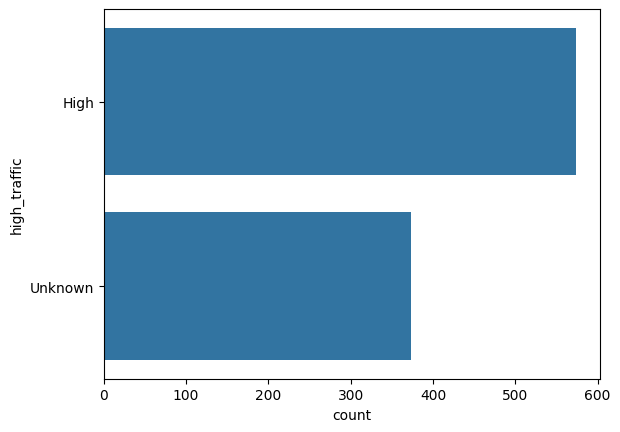

In [14]:
sns.countplot(recipe_site_traffic['high_traffic'])

#### Dealing with missing values

In [15]:
recipe_site_traffic.isna().sum().sort_values()

recipe           0
category         0
servings         0
high_traffic     0
calories        52
carbohydrate    52
sugar           52
protein         52
dtype: int64

In [16]:
# Duplicate recipes
duplicate_rows = recipe_site_traffic[['calories','carbohydrate', 'sugar', 'protein', 'servings', 'category','high_traffic']].duplicated()
duplicate_rows.value_counts()

False    922
True      25
Name: count, dtype: int64

No one would need to show a High traffic recipe two times on the platform so let's delete duplicates.

In [17]:
recipe_site_traffic[duplicate_rows]

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
89,90,NaN,NaN,NaN,NaN,Pork,6,High
209,210,NaN,NaN,NaN,NaN,Dessert,2,High
262,263,NaN,NaN,NaN,NaN,Chicken,4,Unknown
351,352,NaN,NaN,NaN,NaN,Potato,4,High
354,355,NaN,NaN,NaN,NaN,Pork,4,High
376,377,NaN,NaN,NaN,NaN,Pork,6,High
388,389,NaN,NaN,NaN,NaN,Lunch/Snacks,4,High
427,428,NaN,NaN,NaN,NaN,Vegetable,4,High
455,456,NaN,NaN,NaN,NaN,Pork,6,High
538,539,NaN,NaN,NaN,NaN,Vegetable,4,High


All duplicate rows have missing values in the nutrition components ('calories', 'carbohydrate', 'sugar' and 'protein') columns, without them we cannot define a recipe.

We have two options :
1. delete duplicates and then fill the missing values with mean (or median to reduce the effect of outliers in the futur).
2. delete all rows that contain missing values in nutrition components.

I personnaly don't agree with the first option because filling data will be like creating fictional recipes. It's true that we can suggest some values to the manager but we already have high traffic for recipes with missing values so it is highly likely that it's an error. This is why i'm going with the second option.

In [18]:
nutrition_cols = ['calories', 'carbohydrate', 'sugar', 'protein']
missing_values_df = recipe_site_traffic[recipe_site_traffic[nutrition_cols].isnull().all(axis=1)]
missing_values_df.sample(10)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
297,298,NaN,NaN,NaN,NaN,Lunch/Snacks,6,Unknown
116,117,NaN,NaN,NaN,NaN,Chicken,6,High
351,352,NaN,NaN,NaN,NaN,Potato,4,High
555,556,NaN,NaN,NaN,NaN,Meat,2,Unknown
376,377,NaN,NaN,NaN,NaN,Pork,6,High
280,281,NaN,NaN,NaN,NaN,Meat,1,High
427,428,NaN,NaN,NaN,NaN,Vegetable,4,High
212,213,NaN,NaN,NaN,NaN,Dessert,4,High
82,83,NaN,NaN,NaN,NaN,Meat,4,High
896,897,NaN,NaN,NaN,NaN,Chicken,6,High


We count 52 observations where 'calories', 'carbohydrate', 'sugar' and 'protein' columns all have null values at once (only 5% of the data). Now we can drop the corresponding rows and we're sure that we're dropping only rows where we have null values for the four items all at once.

In [19]:
recipe_site_traffic_cleaned_df = recipe_site_traffic.copy()
recipe_site_traffic_cleaned_df = recipe_site_traffic_cleaned_df.dropna(subset=nutrition_cols, how='all')
recipe_site_traffic_cleaned_df.sample(10)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
238,239,581.70,11.48,7.94,13.64,Chicken,4,High
523,524,74.78,2.97,7.55,0.70,Beverages,6,Unknown
895,896,309.05,126.18,37.76,2.76,Dessert,4,High
624,625,68.54,7.55,17.68,0.93,Beverages,4,Unknown
464,465,108.58,21.67,0.24,11.24,Vegetable,1,High
552,553,241.33,32.19,1.43,1.00,Vegetable,2,High
94,95,826.83,145.32,6.48,3.04,Potato,4,High
837,838,12.63,40.82,0.59,3.41,Vegetable,4,High
596,597,287.32,10.24,2.32,2.18,Beverages,1,Unknown
22,23,82.73,3.17,7.95,26.04,Breakfast,4,Unknown


In [20]:
recipe_site_traffic_cleaned_df.shape

(895, 8)

Now that we have a clean dataset, let's validate it and explore it !

In [21]:
# Quick check
recipe_site_traffic_cleaned_df['high_traffic'].value_counts('Unknown')*100

high_traffic
High       59.776536
Unknown    40.223464
Name: proportion, dtype: float64

40% of the data is still to predict (Unknown).

## <span style="color:green"><b> 1. Data Validation</b></span>

#### Dataset Description

In [22]:
recipe_site_traffic_cleaned_df.describe()

,recipe,calories,carbohydrate,sugar,protein,servings
count,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000
mean,473.652514,435.939196,35.069676,9.046547,24.149296,3.458101
std,272.763283,453.020997,43.949032,14.679176,36.369739,1.735979
min,2.000000,0.140000,0.030000,0.010000,0.000000,1.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000,2.000000
50%,475.000000,288.550000,21.480000,4.550000,10.800000,4.000000
75%,708.500000,597.650000,44.965000,9.800000,30.200000,4.000000
max,947.000000,3633.160000,530.420000,148.750000,363.360000,6.000000


#### Interquartile Range (IQR)

In [23]:
Q1 = recipe_site_traffic_cleaned_df[nutrition_cols].quantile(0.25)
Q3 = recipe_site_traffic_cleaned_df[nutrition_cols].quantile(0.75)

IQR = Q3 - Q1

print("First Quantile\n", Q1, "\n\nThird Quantile\n", Q3)

# Interquantile Range
print("\nIQR\n", IQR)

First Quantile
 calories        110.430
carbohydrate      8.375
sugar             1.690
protein           3.195
Name: 0.25, dtype: float64 

Third Quantile
 calories        597.650
carbohydrate     44.965
sugar             9.800
protein          30.200
Name: 0.75, dtype: float64

IQR
 calories        487.220
carbohydrate     36.590
sugar             8.110
protein          27.005
dtype: float64


While the columns for 'recipe' and 'servings' may offer limited insight, the remaining columns in the dataset provide more substantial information for analysis.
I can read the results but the table is more insightful.
Let me analyze the 'calories' for you :
- Skewness: The median (288.55) being less than the mean (435.94) suggests a positively skewed distribution. This skewness is further indicated by the fact that the IQR (487.22) is larger than the mean.
- Variability: The large difference between the IQR and the median indicates substantial variability in the middle 50% of the dataset.
- Outliers: The large difference between the mean and the median, as well as the large IQR, suggest the possible presence of outliers on the higher end of the distribution. These outliers are likely influencing the mean and contributing to the positively skewed distribution.
- Central Tendency: The fact that the median is substantially lower than the mean indicates that the distribution is heavily influenced by the higher values, pulling the mean upwards. In this case, the median may be a more representative measure of central tendency, especially in the presence of outliers.

## <span style="color:green"><b> 2. Data Exploration</b></span>

To validate the previous interpretations about calories variable let's visualize data.

<Axes: ylabel='calories'>

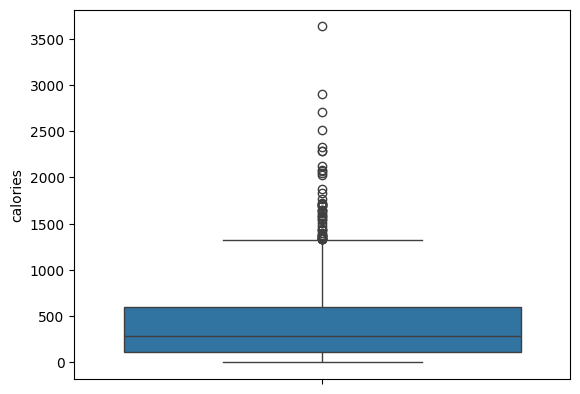

In [24]:
sns.boxplot(data=recipe_site_traffic_cleaned_df['calories'])

Most of 'calories' data is concentrated in the range [100,600]. Here we can observe the presence of outliers that could affect our analysis.

[]

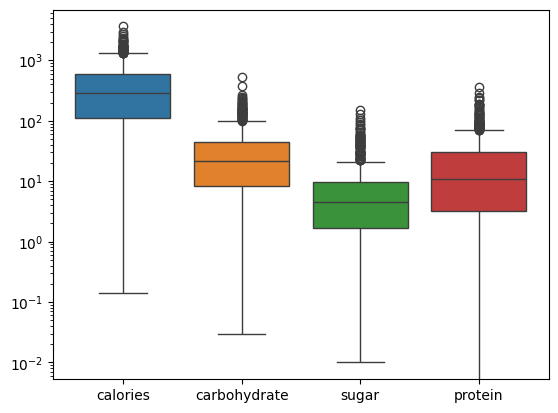

In [25]:
# Boxplot for all nutrition components
sns.boxplot(data=recipe_site_traffic_cleaned_df[nutrition_cols])
plt.semilogy()

We must be careful with the observed outliers in our data.

Now let's verify the distribution skewness of 'calories'

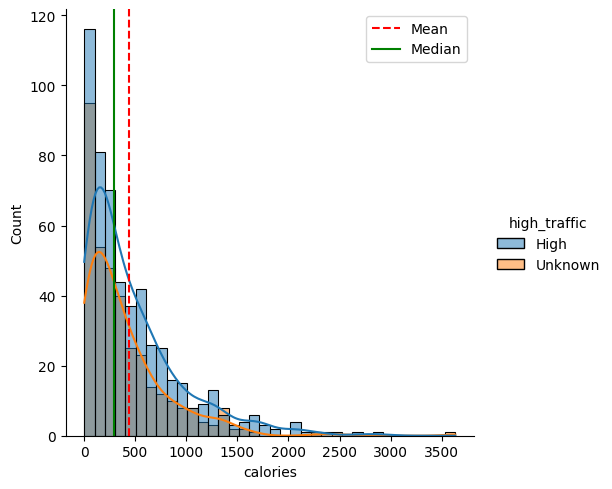

In [26]:
# distribution plot for calories while adding the target 'high_traffic' to specify 'High' and 'Unknown' traffic
sns.displot(recipe_site_traffic_cleaned_df, x=recipe_site_traffic_cleaned_df['calories'], kde='true', hue='high_traffic')

# vertical red line at the mean
plt.axvline(recipe_site_traffic_cleaned_df['calories'].mean(), color='r', linestyle='--', label='Mean')

# vertical green line at the median
plt.axvline(recipe_site_traffic_cleaned_df['calories'].median(), color='g', linestyle='-', label='Median')

# show legend and plot
plt.legend()
plt.show()

In [27]:
# skewness calculation for calories
skewness = recipe_site_traffic_cleaned_df['calories'].skew()
print("Skewness:", skewness)

Skewness: 2.036150959685193


The value of skewness is greater than 1, this distribution is highly skewed to the right.

#### Relationship between two variables

Out of curiosity, let's plot the correlation matrix of nutrition components.

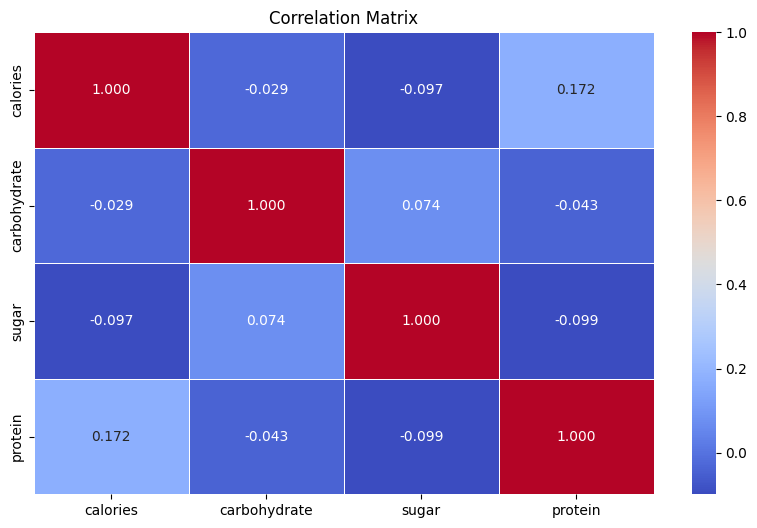

In [28]:
correlation_matrix = recipe_site_traffic_cleaned_df[nutrition_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In this matrix we can see if we have positive or negative correlation between two variables (calories vs protein, sugar vs carbohydrate, sugar vs calories, etc.), but it is important to note that this doesn't prove any relationship between these variables because one variable (calories for example) can depend on other factors and in some cases on all the other variables and the corresponding meal. In the following analysis we will study the relationship between nutrition components and meal categories for all the servings.

Now a pairplot to analyze the distribution of each item and the distribution of each correlation between the varaibles.

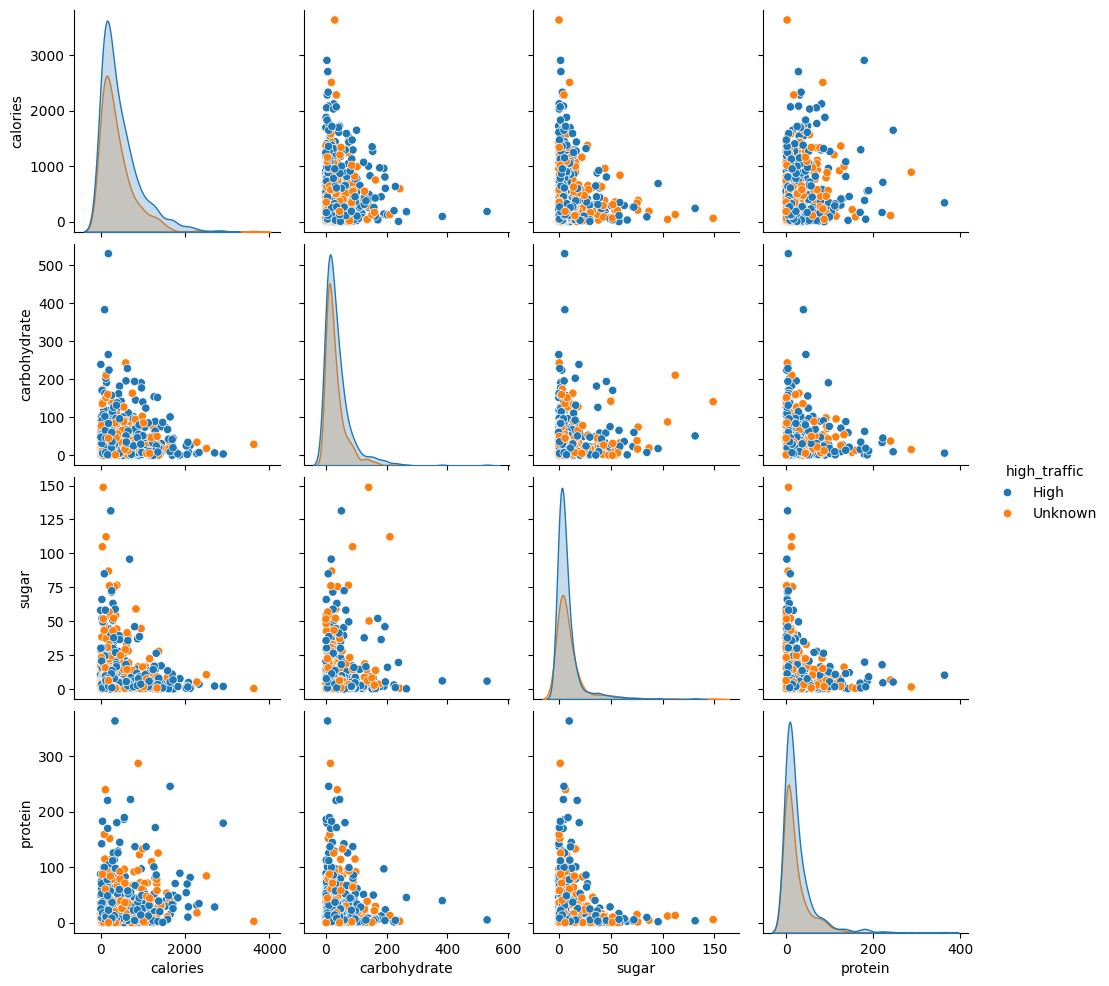

In [29]:
sns.pairplot(recipe_site_traffic_cleaned_df.loc[:, ['calories', 'carbohydrate', 'sugar', 'protein', 'high_traffic']], hue='high_traffic')

All recipes are highly skewed. This skewness is due to the presence of outliers. For example in one standard serving it is highly unlikely to have 1878.82 calories for a chicken based meal !

#### Relationship between nutrition components and categories for different servings

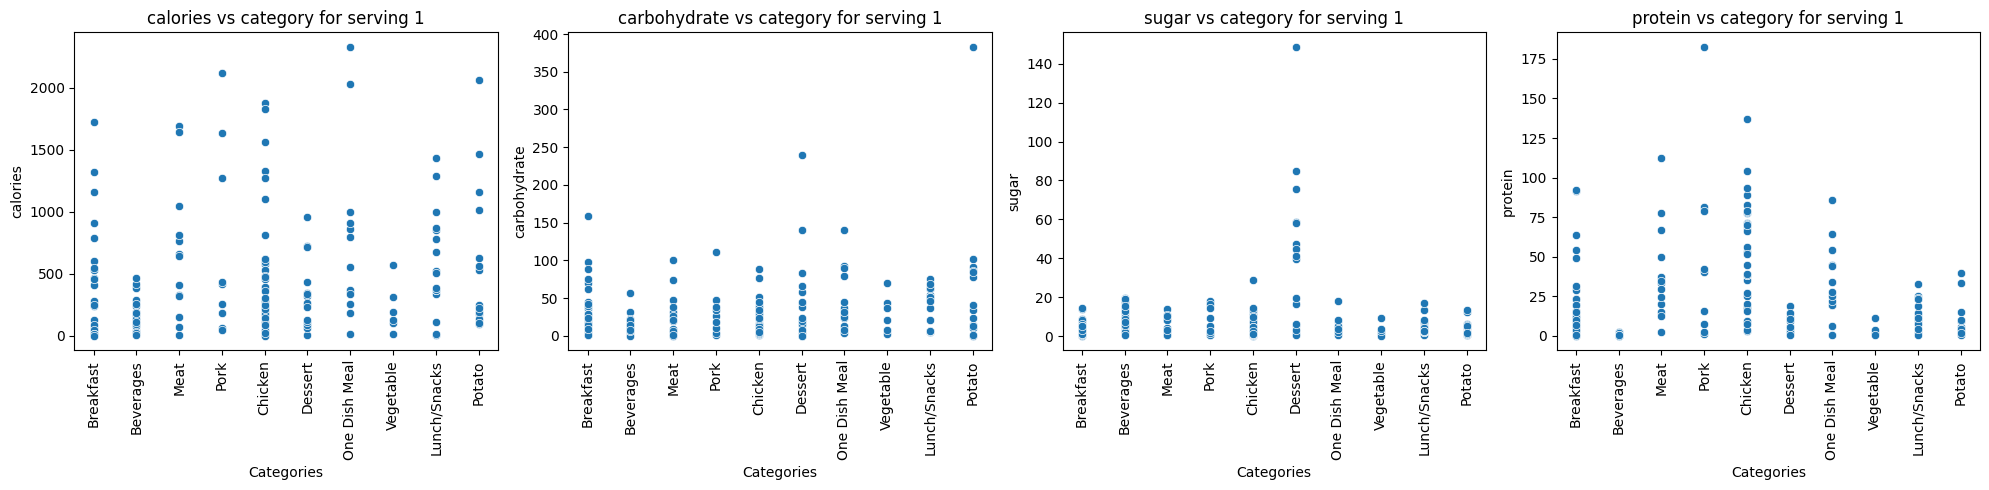

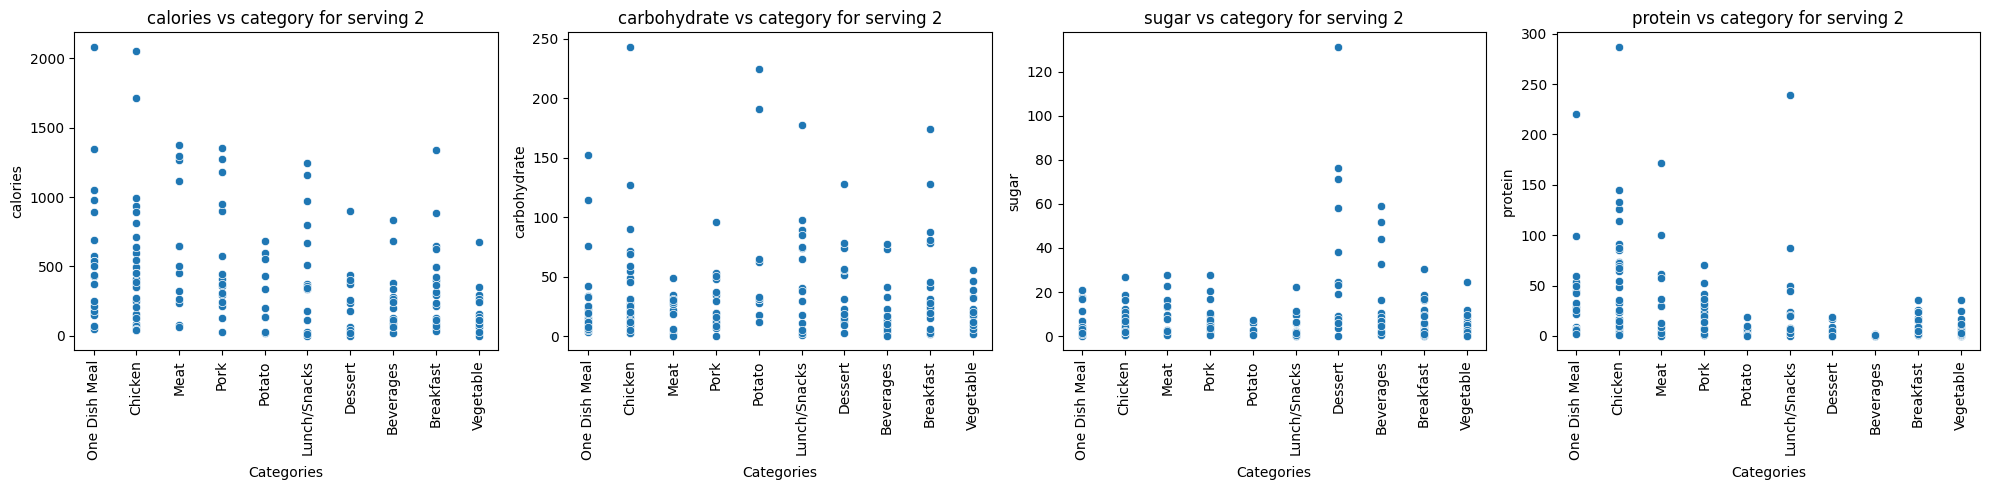

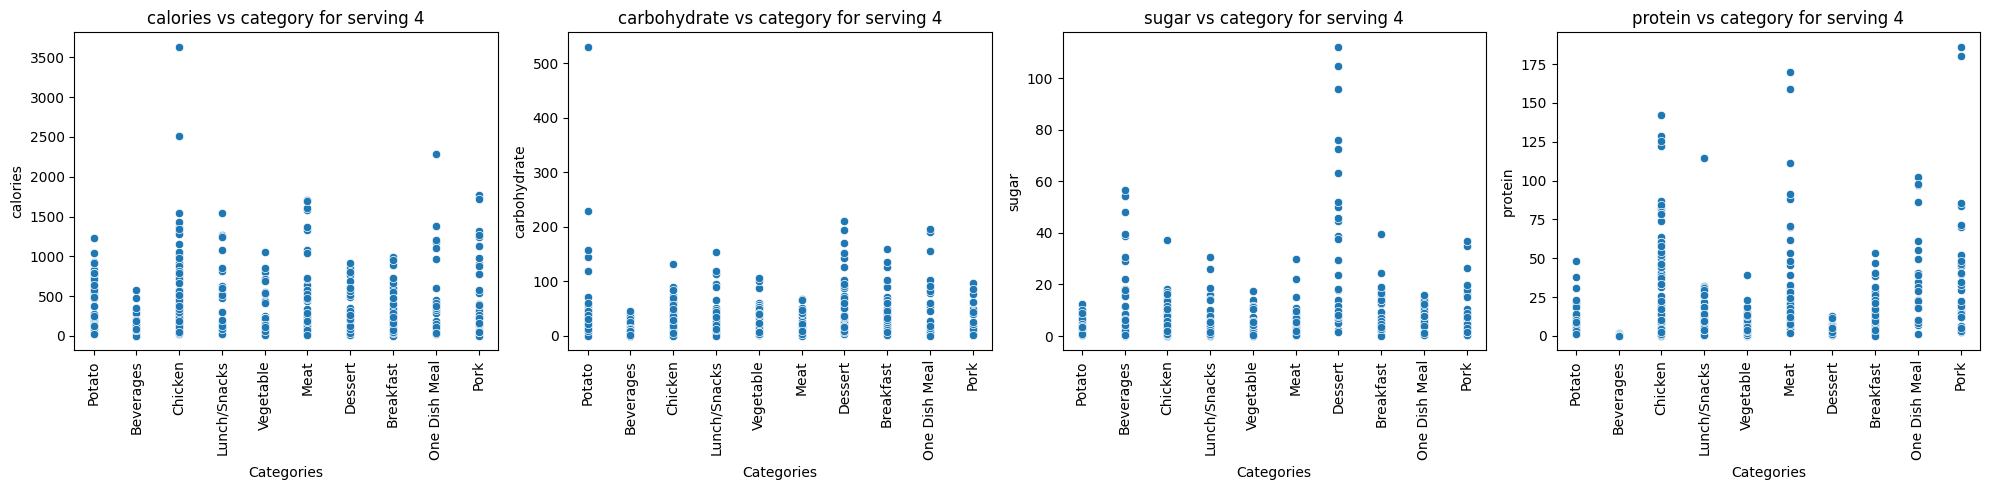

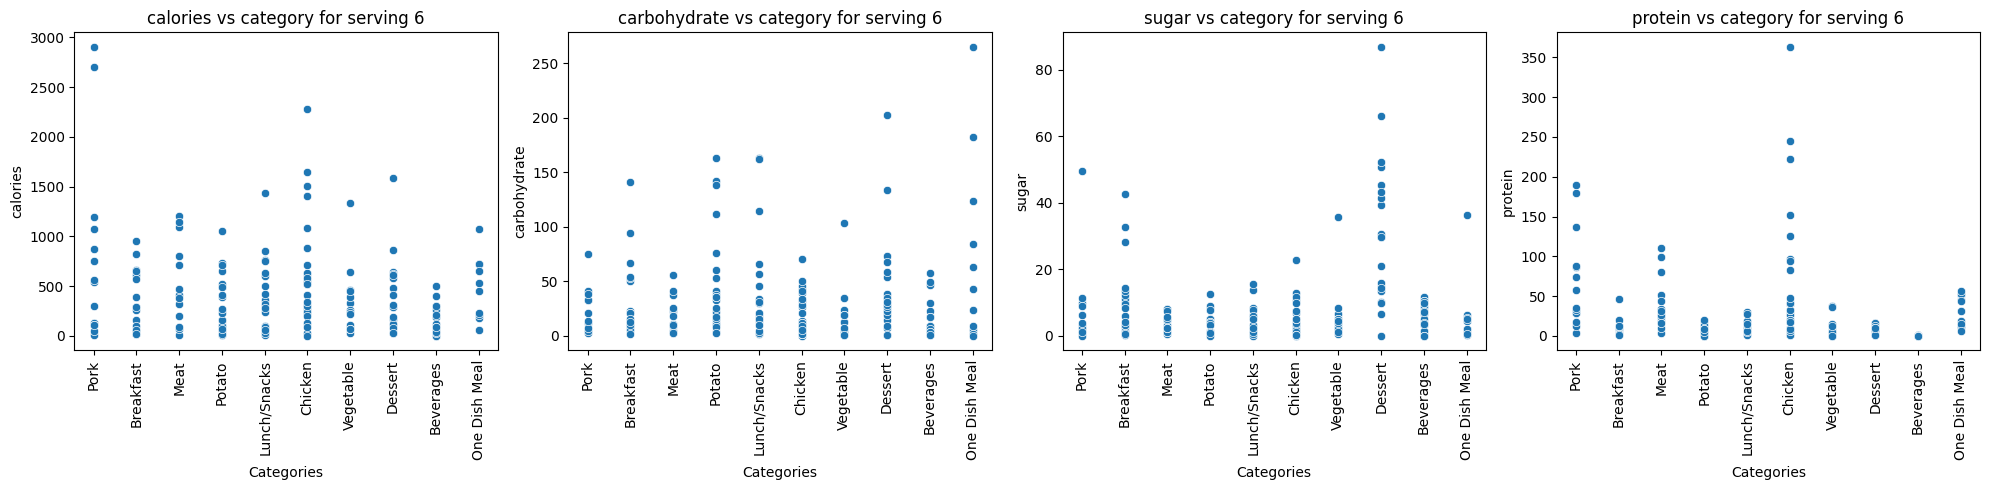

In [30]:
# Plotting macronutrients as function of category for available servings
for j in [1,2,4,6]:
    filterj = recipe_site_traffic_cleaned_df[recipe_site_traffic_cleaned_df['servings']==j]
    columns_to_plot = filterj[['calories', 'carbohydrate', 'sugar', 'protein']]

    # figure and subplots
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # scatter plot in a separate subplot
    for i, col in enumerate(columns_to_plot):
        sns.scatterplot(x=filterj['category'], y=filterj[col], ax=axes[i])
        axes[i].set_xlabel('Categories')
        axes[i].set_ylabel(str(col))
        axes[i].set_title(f'{col} vs category for serving {j}')
        axes[i].tick_params(axis='x', rotation=90)  # Rotate x-axis tick labels if needed

    # layout adjusting and plot display
    plt.tight_layout()
    plt.show()

#### Some interactive plots to better understand our data

In [31]:
import plotly.express as px

# piechart for 'category' variable showing the distribution of site traffic for different categories
px.sunburst(recipe_site_traffic_cleaned_df, path=['high_traffic', 'category'])

In [32]:
# distribution of site traffic for different servings
px.sunburst(recipe_site_traffic_cleaned_df, path=['high_traffic', 'servings'])

### Removing outliers

In order to get better results we need to remove outliers.

#### Using Z-Score

In [33]:
df = recipe_site_traffic_cleaned_df.copy()

In [34]:
from scipy.stats import zscore

z_scores = df[nutrition_cols].apply(zscore)

# threshold for identifying outliers
threshold = 3

# Find outliers
outliers_df = np.abs(z_scores) > threshold
outliers_df.sample(50)

,calories,carbohydrate,sugar,protein
347,False,False,False,False
32,False,False,False,False
597,False,False,False,False
714,False,False,False,False
842,False,False,False,False
470,False,False,False,False
885,False,False,False,False
330,False,False,False,False
562,False,False,False,False
411,False,False,False,False


Seems to be working well.

In [35]:
# dataset without outliers using z-score
df_zscore = df[~outliers_df.any(axis=1)]
df_zscore.head(10)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,Unknown
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,Unknown
5,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High
6,7,183.94,47.95,9.75,46.71,Chicken,4,Unknown
7,8,299.14,3.17,0.40,32.40,Lunch/Snacks,4,Unknown
8,9,538.52,3.78,3.37,3.79,Pork,6,High
9,10,248.28,48.54,3.99,113.85,Chicken,2,Unknown
10,11,170.12,17.63,4.10,0.91,Beverages,1,Unknown


In [36]:
df_zscore.shape

(826, 8)

In [37]:
df_zscore['high_traffic'].value_counts()

high_traffic
High       486
Unknown    340
Name: count, dtype: int64

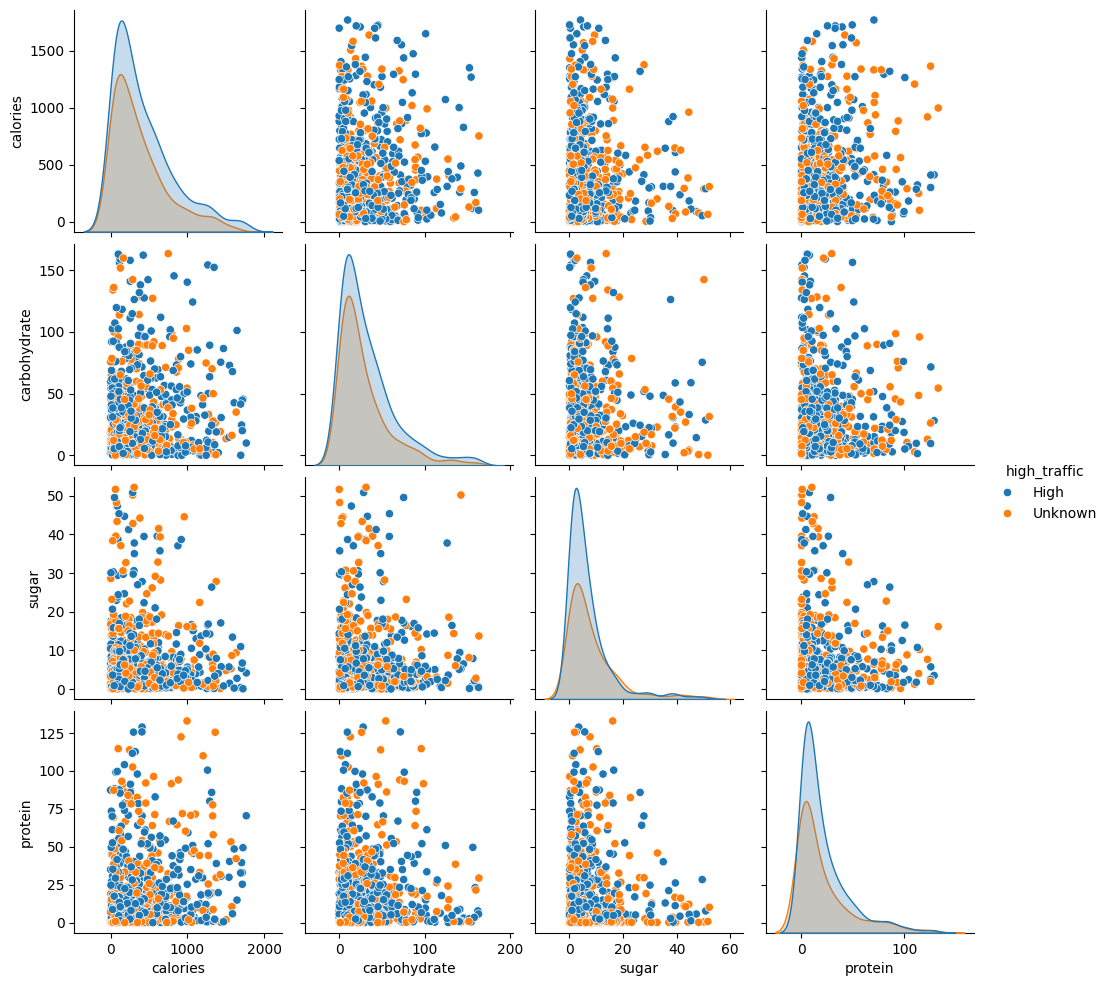

In [38]:
# a pairplot for our data after removing outliers using z-score
sns.pairplot(df_zscore[['calories', 'carbohydrate', 'sugar', 'protein', 'high_traffic']], hue='high_traffic')

[]

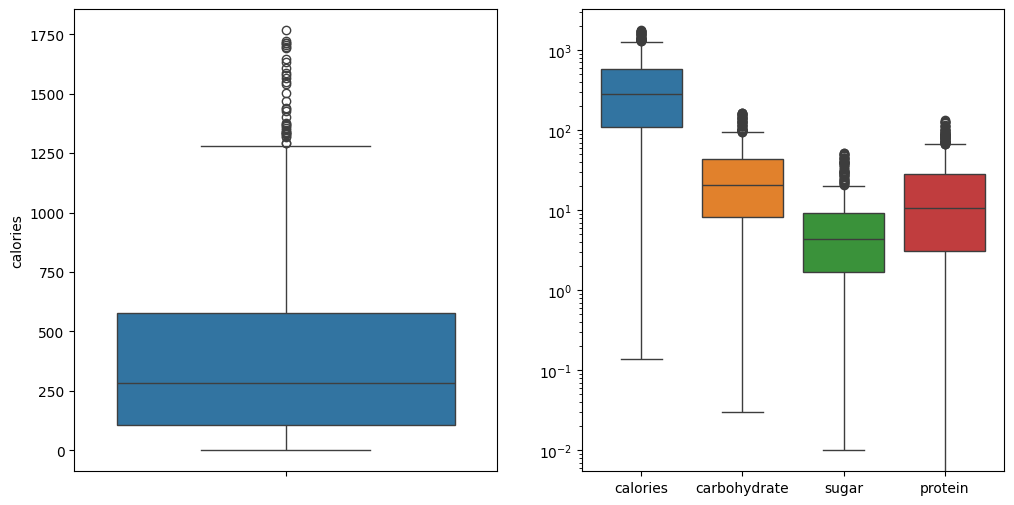

In [39]:
# boxplot for 'calories' and then all nutrition components to show the effect on outliers
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(y=df_zscore['calories'], ax=axes[0])

sns.boxplot(data=df_zscore[nutrition_cols], ax=axes[1])
plt.semilogy()

Looks like we reduced the effect of outliers.

#### Using IQR

In [40]:
# Calculating IQR for selected columns
Q1 = df[nutrition_cols].quantile(0.25)
Q3 = df[nutrition_cols].quantile(0.75)
IQR = Q3 - Q1

# Defining criterion for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

criterion = (df[nutrition_cols] < lower_bound) | (df[nutrition_cols] > upper_bound)

# Identifying outlier rows
outlier_rows = criterion.any(axis=1)

# Removing outliers
df_iqr = df[~outlier_rows]
df_iqr.head(10)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,Unknown
4,5,27.05,1.85,0.80,0.53,Beverages,4,Unknown
5,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High
6,7,183.94,47.95,9.75,46.71,Chicken,4,Unknown
7,8,299.14,3.17,0.40,32.40,Lunch/Snacks,4,Unknown
8,9,538.52,3.78,3.37,3.79,Pork,6,High
10,11,170.12,17.63,4.10,0.91,Beverages,1,Unknown
11,12,155.80,8.27,9.78,11.55,Breakfast,6,Unknown
12,13,274.63,23.49,1.56,2.57,Potato,4,High


In [41]:
df_iqr.shape

(654, 8)

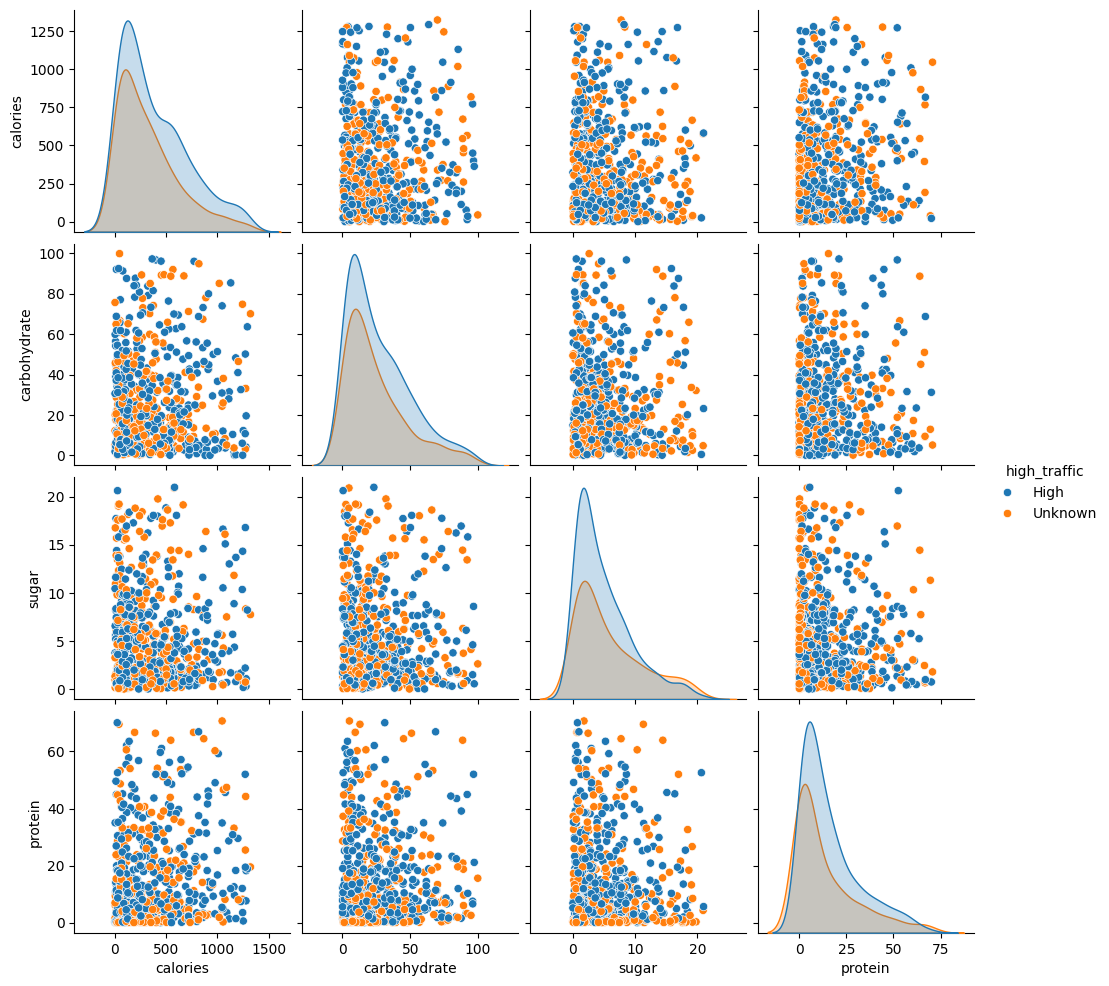

In [42]:
sns.pairplot(df_iqr[['calories', 'carbohydrate', 'sugar', 'protein', 'high_traffic']], hue='high_traffic')

[]

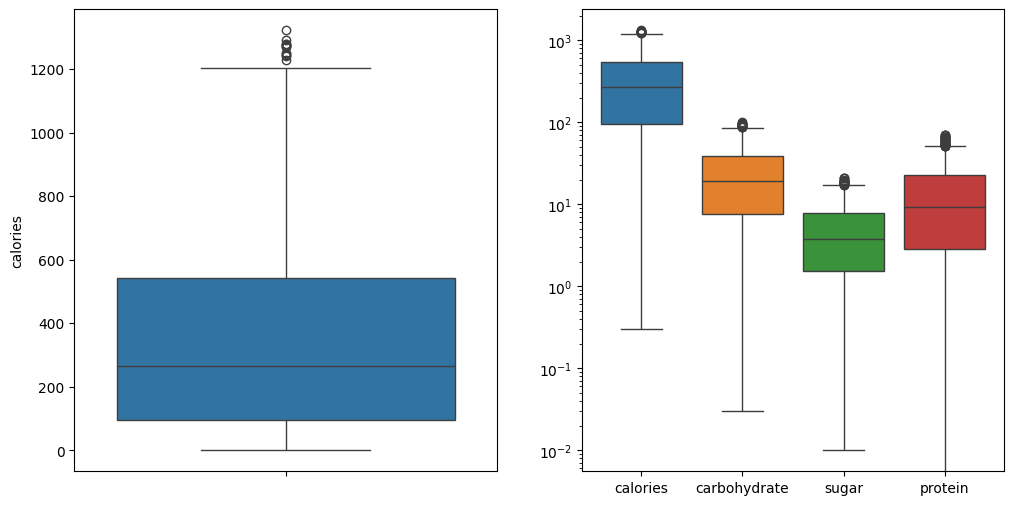

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(y=df_iqr['calories'], ax=axes[0])

sns.boxplot(data=df_iqr[nutrition_cols], ax=axes[1])
plt.semilogy()

IQR apporach seems to be more powerful against outliers but by using IQR we lose about 27% of the data (comparing to the already cleaned dataset 'recipe_site_traffic_cleaned_df'). For this reason i will not be implementing it in my analysis.

I'm going to use the df_zscore dataset and a scaler that is robust against outliers in order to mitigate their effect.

In [44]:
robust_scaler = RobustScaler()

## <span style="color:green"><b> 3. Model Developement</b></span>

Traffic as a variable can take a binary state : {'High', 'Unknown'}. As a result, we can use logistic regression to classify traffic. Other models like Decision Trees, Random Forests, Support Vector Machines (SVM), and Gradient Boosting Machines (GBM) also can be used. I personnaly prefer to apply model selection to select the most suitable model for any problem.

Before implementing any predictive model we must convert categorical data to numerical. I will be using a Label Encoder for this purpose.

In [45]:
label_encoder = LabelEncoder()

In [46]:
df_zscore_encoded = df_zscore.copy()

# encode category data using label encoder
df_zscore_encoded['category_encoded'] = label_encoder.fit_transform(df_zscore['category'])

# encode high_traffic data by replacing High with 1 and Unknown with 0
df_zscore_encoded['traffic_encoded'] = df_zscore['high_traffic'].replace({'High':1, 'Unknown':0})

# no need to keep strings data now
df_zscore_encoded.drop(columns=['high_traffic', 'category'], inplace=True)

# here i define the matrix containing features i'll be using to predict the target
X = df_zscore_encoded.drop(columns=['traffic_encoded'])
X.drop(columns=['recipe'], inplace=True) # Won't 'recipe' now but will i will need it for reproductibility
X.sample(15)

,calories,carbohydrate,sugar,protein,servings,category_encoded
519,138.81,12.91,14.61,0.04,1,0
766,217.78,0.62,4.51,0.46,6,9
686,975.90,10.81,3.04,60.25,4,2
705,458.53,28.89,6.32,92.01,1,1
873,161.30,35.29,3.23,3.51,6,8
888,1129.21,85.35,1.69,11.92,4,7
881,219.25,3.19,5.82,12.75,4,9
76,557.66,36.78,3.00,19.55,1,6
787,100.83,162.91,0.41,5.68,6,8
133,959.51,4.40,44.54,12.12,1,3


Of course we will not scale data in recipe, servings and category data because that doesn't make any sense (categorical data).

In [47]:
# std_scaler = StandardScaler() # you could use it to test the difference
X_scaled = X.copy()
X_scaled[nutrition_cols] = robust_scaler.fit_transform(X[nutrition_cols])
X_scaled

,calories,carbohydrate,sugar,protein,servings,category_encoded
1,-0.531109,0.507658,-0.497674,-0.378836,4,8
2,1.340938,0.626159,-0.174751,-0.301731,1,1
3,-0.399994,0.277558,4.548173,-0.414241,4,0
4,-0.549067,-0.548213,-0.479070,-0.394178,4,0
5,0.865620,-0.501906,-0.366113,1.706530,2,6
...,...,...,...,...,...,...
941,-0.210020,1.812900,-0.322259,0.466168,4,2
942,1.866509,-0.448695,2.390033,1.324548,2,4
944,1.420737,0.244769,-0.110963,0.130606,2,7
945,-0.038749,0.427411,-0.456478,-0.097561,6,8


In [48]:
# Target
y = df_zscore_encoded['traffic_encoded']
pd.DataFrame(y).head(5)

,traffic_encoded
1,1
2,0
3,1
4,0
5,1


### <b> Model Selection </b>

In [49]:
# Models that i'm testing

from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, SGDClassifier, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier #, VotingClassifier, AdaBoostClassifier, IsolationForest
from sklearn.svm import SVC #, OneClassSVM
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from xgboost import XGBClassifier


logistic_regression_model = LogisticRegression(random_state=0)
passive_agressive_model = PassiveAggressiveClassifier(random_state=0)
ridge_model = RidgeClassifier(random_state=0)
sgd_model = SGDClassifier(random_state=0)

svc_model = SVC(random_state=0)

knn_model = KNeighborsClassifier()

decision_tree_model = DecisionTreeClassifier(random_state=0)

random_forest_model = RandomForestClassifier(random_state=0)
gradient_boosting_model = GradientBoostingClassifier(random_state=0)
extra_trees_classifier = ExtraTreesClassifier(random_state=0)

naive_model = GaussianNB()

MLP_classifier = MLPClassifier(random_state=0)

models = [
    ("Logistic Regression", logistic_regression_model),
    ("Passive Agressive Classifier", passive_agressive_model),
    ("Ridge Classifier", ridge_model),
    ("SGD Classifier", sgd_model),

    ("SVC", svc_model),
    
    ("KNN Classifier", knn_model),

    ("Decision Tree", decision_tree_model),

    ("Random Forest", random_forest_model),
    ("Gradient Boosting", gradient_boosting_model),
    ("Extra Trees Classifier", extra_trees_classifier),

    ("Naive Bayes", naive_model),

    ("Multi-Perceptron Classifier", MLP_classifier)
    
    ]

In [50]:
def model_comparaison(list_models, X_train, y_train, X_test, y_test):
    
    models_train_accuracies = []
    models_test_accuracies = []
    
    for item in list_models:
        model = item[1]
        model.fit(X_train, y_train) # Model training
        
        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Training set performance
        accuracy_train = accuracy_score(y_pred_train, y_train)
        f1score_train = f1_score(y_pred_train, y_train)
        precision_train = precision_score(y_pred_train, y_train)
        recall_train = recall_score(y_pred_train, y_train)
        roc_auc_train = roc_auc_score(y_pred_train, y_train)
        
        models_train_accuracies.append((item[1], accuracy_train))
        
        # Test set performance
        accuracy_test = accuracy_score(y_pred_test, y_test)
        f1score_test = f1_score(y_pred_test, y_test)
        precision_test = precision_score(y_pred_test, y_test)
        recall_test = recall_score(y_pred_test, y_test)
        roc_auc_test = roc_auc_score(y_pred_test, y_test)
        
        models_test_accuracies.append((item[1], accuracy_test))
        
        print("\033[94mModel:\033[0m", model)
        print("----------------- Training Set Performance ------------------")
        print("- Accuracy=", accuracy_train)
        print("- F1-Score=", f1score_train)
        print("- Precision=", precision_train)
        print("- Recall=", recall_train)
        print("- ROC AUC=", roc_auc_train)
        
        print("----------------- Test Set Performance ----------------------")
        print("- Accuracy=", accuracy_test)
        print("- F1-Score=", f1score_test)
        print("- Precision=", precision_test)
        print("- Recall=", recall_test)
        print("- ROC AUC=", roc_auc_test, "\n")

In [51]:
# # Which split to use ?
# for i in range(10,41,5):
#     print(f"================== \033[91mAt test size= {i/100}\033[0m  ===================")
#     Xi_train, Xi_test, yi_train, yi_test = train_test_split(X_scaled, y, test_size=(i/100), random_state=0)
#     model_comparaison(list_models=models, X_train=Xi_train, y_train=yi_train, X_test=Xi_test, y_test=yi_test)

In [52]:
# Split at test size = 0.15 seems to be the best choice
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=0)
print(X_train.shape, y_train.shape)

(702, 6) (702,)


In [53]:
# Using our best split
model_comparaison(list_models=models, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Model: LogisticRegression(random_state=0)
----------------- Training Set Performance ------------------
- Accuracy= 0.7635327635327636
- F1-Score= 0.7975609756097561
- Precision= 0.7860576923076923
- Recall= 0.8094059405940595
- ROC AUC= 0.755374111236627
----------------- Test Set Performance ----------------------
- Accuracy= 0.75
- F1-Score= 0.7737226277372262
- Precision= 0.7571428571428571
- Recall= 0.7910447761194029
- ROC AUC= 0.7463995810421575 

Model: PassiveAggressiveClassifier(random_state=0)
----------------- Training Set Performance ------------------
- Accuracy= 0.6168091168091168
- F1-Score= 0.7520737327188939
- Precision= 0.9807692307692307
- Recall= 0.6098654708520179
- ROC AUC= 0.6837206142138877
----------------- Test Set Performance ----------------------
- Accuracy= 0.6209677419354839
- F1-Score= 0.748663101604278
- Precision= 1.0
- Recall= 0.5982905982905983
- ROC AUC= 0.7991452991452992 

Model: RidgeClassifier(random_state=0)
----------------- Training Set Perf

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Potential candidates : Logistic regression  model, SVC, Ridge Classifier, KNN Classifier, GaussianNB and MLP Classifier (even hasn't converged yet).

Let's validate these choices by tuning.

### Hyperparameters tunning

In [54]:
# Out of curiosity i display logistic regression coefficients and intercept
print("LR Model coefficients:", logistic_regression_model.coef_)
print("LR Model intercept:", logistic_regression_model.intercept_)

LR Model coefficients: [[-0.05361063  0.07053269 -0.01714008 -0.082978    0.05011317  0.52964428]]
LR Model intercept: [-1.69017158]


In [55]:
# And now some statistics for LR performance on the training data
logit_model = sm.Logit(y_train, sm.add_constant(X_train))
logit_result = logit_model.fit()

# summary of logistic regression results
print(logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.492887
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:        traffic_encoded   No. Observations:                  702
Model:                          Logit   Df Residuals:                      695
Method:                           MLE   Df Model:                            6
Date:                Sun, 30 Jun 2024   Pseudo R-squ.:                  0.2708
Time:                        21:24:47   Log-Likelihood:                -346.01
converged:                       True   LL-Null:                       -474.48
Covariance Type:            nonrobust   LLR p-value:                 1.340e-52
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.6931      0.254     -6.655      0.000      -2.192      -1.195
calories   

In [56]:
# Same for the test data
logit_model = sm.Logit(y_test, sm.add_constant(X_test))
logit_result = logit_model.fit()

# summary of logistic regression results
print(logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.437986
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        traffic_encoded   No. Observations:                  124
Model:                          Logit   Df Residuals:                      117
Method:                           MLE   Df Model:                            6
Date:                Sun, 30 Jun 2024   Pseudo R-squ.:                  0.3604
Time:                        21:24:48   Log-Likelihood:                -54.310
converged:                       True   LL-Null:                       -84.915
Covariance Type:            nonrobust   LLR p-value:                 2.555e-11
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.7611      0.624     -2.823      0.005      -2.984      -0.538
calories   

#### Our models' actual parameters

In [57]:
logistic_regression_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [58]:
svc_model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 0,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [59]:
knn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [60]:
ridge_model.get_params()

{'alpha': 1.0,
 'class_weight': None,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': 0,
 'solver': 'auto',
 'tol': 0.0001}

In [61]:
naive_model.get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [62]:
MLP_classifier.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 0,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [63]:
# Hyperparameters that i'm using to determine the best parameters

lr_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],  # Penalty type
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],  # Regularization strength
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algorithm to use in the optimization problem
    'max_iter': [100, 200, 300],
    'class_weight': [None, 'balanced'],  # Weight of each class
    # 'dual': [True, False],  # Dual or primal formulation
    # 'fit_intercept': [True, False],  # Whether to fit intercept
    'l1_ratio': [0.0, 0.5, 1.0],  # Elastic-Net mixing parameter (for 'elasticnet' penalty)
    # 'warm_start': [True, False],  # Whether to reuse the solution of the previous call to fit as initialization
    'n_jobs': [None, -1]  # Number of CPU cores to use (-1 indicates using all processors)
}

svc_param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'degree': [2, 3, 4, 5],  # Degree of the polynomial kernel function
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'coef0': [0.0, 0.1, 0.5, 1.0],  # Independent term in kernel function
    # 'shrinking': [True, False],  # Whether to use the shrinking heuristic
    # 'probability': [True, False],  # Whether to enable probability estimates
    'class_weight': [None, 'balanced'],  # Weight of each class
    'max_iter': [100, 200, 300],
    'tol': [1e-4, 1e-3, 1e-2],  # Tolerance for stopping criteria
}

knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute nearest neighbors
    'leaf_size': [20, 30, 40],  # Leaf size passed to BallTree or KDTree
    'p': [1, 2]  # Power parameter for the Minkowski metric
}

ridge_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],  # Regularization strength
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],  # Solver for optimization
    'tol': [1e-4, 1e-3, 1e-2],  # Tolerance for stopping criteria
    # 'fit_intercept': [True, False],  # Whether to fit intercept
    'class_weight': [None, 'balanced'],  # Weight of each class
    'max_iter': [100, 200, 300]
}

gaussianNB_param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}


# Define parameter grid for MLP Classifier
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,)],  # sizes of hidden layers
    'activation': ['relu', 'tanh', 'logistic'],  # activation functions
    'solver': ['adam', 'sgd'],  # solvers
    'alpha': [0.0001, 0.001, 0.01],  # Regularization parameter
    'learning_rate': ['constant', 'adaptive'],  # Learning rate schedule
    'learning_rate_init': [0.001, 0.01, 0.1],  # learning rate
    'batch_size': [32, 64, 128],
    'max_iter': [100, 200, 300],
    'tol': [1e-4, 1e-3, 1e-2],  # Tolerance for convergence
    # 'early_stopping': [True, False],  # Whether to use early stopping
    'validation_fraction': [0.1, 0.2, 0.3],  # Fraction of training data to use for validation
    'n_iter_no_change': [5, 10, 15]  # Number of iterations with no improvement to wait before stopping
}

In [64]:
tuning_models = [
    ("Logistic Regression", LogisticRegression(random_state=0), lr_param_grid),
    ("SVM", SVC(random_state=0), svc_param_grid),
    ("KNN Classifier", KNeighborsClassifier(), knn_param_grid),
    ("Ridge Classifier", RidgeClassifier(random_state=0),ridge_param_grid),
    ("Naive Bayes", GaussianNB(),gaussianNB_param_grid),
    ("Multi-Perceptron Classifier", MLPClassifier(random_state=0),mlp_param_grid)
]

#### Using GridSearchCV

In [65]:
# # Grid Search
# for name, model, params in tuning_models:
#     grid_search = GridSearchCV(estimator=model, param_grid=params, cv=10, verbose=1, scoring='accuracy')
#     grid_search.fit(X_train, y_train)

#     # best hyperparameters found
#     print(f"Best Hyperparameters for {name}", grid_search.best_params_)

#     # best model
#     best_model = grid_search.best_estimator_

#     # Evaluate the best model on the test set
#     best_model_accuracy = best_model.score(X_test, y_test)

#     print(f"Best Accuracy for {name} model", best_model_accuracy, "\n")

Because GridSearch is taking forever (because it searches all possible combinations) i'll be suing randomized search instead that is faster and still provided optimal solutions.

#### Using RandomizedSearchCV

In [66]:
model_param = {}
np.random.seed(0)

for name, model, params in tuning_models:
    randomized_search = RandomizedSearchCV(estimator=model,
                                          param_distributions=params,
                                          cv=10,
                                          verbose=1,
                                          n_jobs=-1)
    randomized_search.fit(X_train, y_train)
    model_param[name] = randomized_search.best_params_
    best_score = randomized_search.score(X_test,y_test)
    print("Accuracy:", best_score)

for model_name in model_param:
    print(f"Best parameters for {model_name} : {model_param[model_name]}")

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skle

Accuracy: 0.75
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Accuracy: 0.75
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScale

Accuracy: 0.782258064516129
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Accuracy: 0.7419354838709677
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Accuracy: 0.7580645161290323
Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning:

The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) re

Accuracy: 0.7580645161290323
Best parameters for Logistic Regression : {'solver': 'lbfgs', 'penalty': 'l2', 'n_jobs': -1, 'max_iter': 100, 'l1_ratio': 0.5, 'class_weight': None, 'C': 1.0}
Best parameters for SVM : {'tol': 0.001, 'max_iter': 300, 'kernel': 'linear', 'gamma': 'scale', 'degree': 2, 'coef0': 0.1, 'class_weight': None, 'C': 0.01}
Best parameters for KNN Classifier : {'weights': 'uniform', 'p': 1, 'n_neighbors': 7, 'leaf_size': 30, 'algorithm': 'brute'}
Best parameters for Ridge Classifier : {'tol': 0.001, 'solver': 'lsqr', 'max_iter': 200, 'class_weight': None, 'alpha': 0.001}
Best parameters for Naive Bayes : {'var_smoothing': 1e-09}
Best parameters for Multi-Perceptron Classifier : {'validation_fraction': 0.3, 'tol': 0.001, 'solver': 'sgd', 'n_iter_no_change': 10, 'max_iter': 300, 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (150,), 'batch_size': 32, 'alpha': 0.01, 'activation': 'logistic'}


In [67]:
lr_model_tuned = LogisticRegression(solver='lbfgs', penalty='l2', n_jobs= -1, max_iter= 100, l1_ratio= 0.5, class_weight= None, C= 0.1)
svc_model_tuned = SVC(tol=0.001, max_iter=300, kernel='linear', gamma='scale', degree=2, coef0=1.0, class_weight=None, C= 0.01)
knn_model_tuned = KNeighborsClassifier(weights='uniform', p=1, n_neighbors=7, leaf_size=30, algorithm='brute')
ridge_model_tuned = RidgeClassifier(tol=0.001, solver='lsqr', max_iter=200, class_weight= None, alpha= 0.001)
naive_model_tuned = GaussianNB(var_smoothing= 1e-09)
MLP_classifier_tuned = MLPClassifier(validation_fraction=0.3, tol= 0.001, solver= 'sgd', n_iter_no_change= 10, max_iter= 300, 
                                     learning_rate_init= 0.01, learning_rate= 'adaptive', hidden_layer_sizes= (150,), batch_size= 32, 
                                     alpha= 0.01, activation= 'logistic')

### <b> Model Evaluation </b>

### <span style="color:darkorange"><b> Learning</b></span>

In [68]:
lr_model_tuned.fit(X_train, y_train)
lr_pred = lr_model_tuned.predict(X_test)
print(classification_report(lr_pred, y_test))

              precision    recall  f1-score   support

           0       0.74      0.70      0.72        57
           1       0.76      0.79      0.77        67

    accuracy                           0.75       124
   macro avg       0.75      0.75      0.75       124
weighted avg       0.75      0.75      0.75       124



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)



In [69]:
svc_model_tuned.fit(X_train, y_train)
svc_pred = svc_model_tuned.predict(X_test)
print(classification_report(svc_pred, y_test))

              precision    recall  f1-score   support

           0       0.76      0.69      0.73        59
           1       0.74      0.80      0.77        65

    accuracy                           0.75       124
   macro avg       0.75      0.75      0.75       124
weighted avg       0.75      0.75      0.75       124



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



In [70]:
knn_model_tuned.fit(X_train, y_train)
knn_pred = knn_model_tuned.predict(X_test)
print(classification_report(knn_pred, y_test))

              precision    recall  f1-score   support

           0       0.74      0.75      0.75        53
           1       0.81      0.80      0.81        71

    accuracy                           0.78       124
   macro avg       0.78      0.78      0.78       124
weighted avg       0.78      0.78      0.78       124



In [71]:
ridge_model_tuned.fit(X_train, y_train)
ridge_pred = ridge_model_tuned.predict(X_test)
print(classification_report(ridge_pred, y_test))

              precision    recall  f1-score   support

           0       0.74      0.69      0.71        58
           1       0.74      0.79      0.76        66

    accuracy                           0.74       124
   macro avg       0.74      0.74      0.74       124
weighted avg       0.74      0.74      0.74       124



In [72]:
naive_model_tuned.fit(X_train, y_train)
nb_pred = naive_model_tuned.predict(X_test)
print(classification_report(nb_pred, y_test))

              precision    recall  f1-score   support

           0       0.74      0.71      0.73        56
           1       0.77      0.79      0.78        68

    accuracy                           0.76       124
   macro avg       0.76      0.75      0.75       124
weighted avg       0.76      0.76      0.76       124



In [73]:
MLP_classifier_tuned.fit(X_train, y_train)
mlp_pred = MLP_classifier_tuned.predict(X_test)
print(classification_report(mlp_pred, y_test))

              precision    recall  f1-score   support

           0       0.74      0.71      0.73        56
           1       0.77      0.79      0.78        68

    accuracy                           0.76       124
   macro avg       0.76      0.75      0.75       124
weighted avg       0.76      0.76      0.76       124



### <span style="color:darkorange"><b> Generalization</b></span>

In [74]:
lr_predictions = lr_model_tuned.predict(X_scaled)
print(classification_report(lr_predictions, y))

              precision    recall  f1-score   support

           0       0.73      0.70      0.72       355
           1       0.78      0.81      0.79       471

    accuracy                           0.76       826
   macro avg       0.76      0.75      0.76       826
weighted avg       0.76      0.76      0.76       826



In [75]:
svc_predictions = svc_model_tuned.predict(X_scaled)
print(classification_report(svc_predictions, y))

              precision    recall  f1-score   support

           0       0.76      0.69      0.72       375
           1       0.76      0.82      0.79       451

    accuracy                           0.76       826
   macro avg       0.76      0.75      0.75       826
weighted avg       0.76      0.76      0.76       826



In [76]:
knn_predictions = knn_model_tuned.predict(X_scaled)
print(classification_report(knn_predictions, y))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73       329
           1       0.83      0.81      0.82       497

    accuracy                           0.78       826
   macro avg       0.77      0.77      0.77       826
weighted avg       0.78      0.78      0.78       826



In [77]:
ridge_predictions = ridge_model_tuned.predict(X_scaled)
print(classification_report(ridge_predictions, y))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72       368
           1       0.77      0.81      0.79       458

    accuracy                           0.76       826
   macro avg       0.76      0.75      0.76       826
weighted avg       0.76      0.76      0.76       826



In [78]:
gaussianNB_predicitons = naive_model_tuned.predict(X_scaled)
print(classification_report(gaussianNB_predicitons, y))

              precision    recall  f1-score   support

           0       0.76      0.68      0.72       380
           1       0.75      0.82      0.78       446

    accuracy                           0.75       826
   macro avg       0.75      0.75      0.75       826
weighted avg       0.75      0.75      0.75       826



In [79]:
mlp_predictions = MLP_classifier_tuned.predict(X_scaled)
print(classification_report(mlp_predictions, y))

              precision    recall  f1-score   support

           0       0.72      0.71      0.71       346
           1       0.79      0.80      0.80       480

    accuracy                           0.76       826
   macro avg       0.75      0.75      0.75       826
weighted avg       0.76      0.76      0.76       826



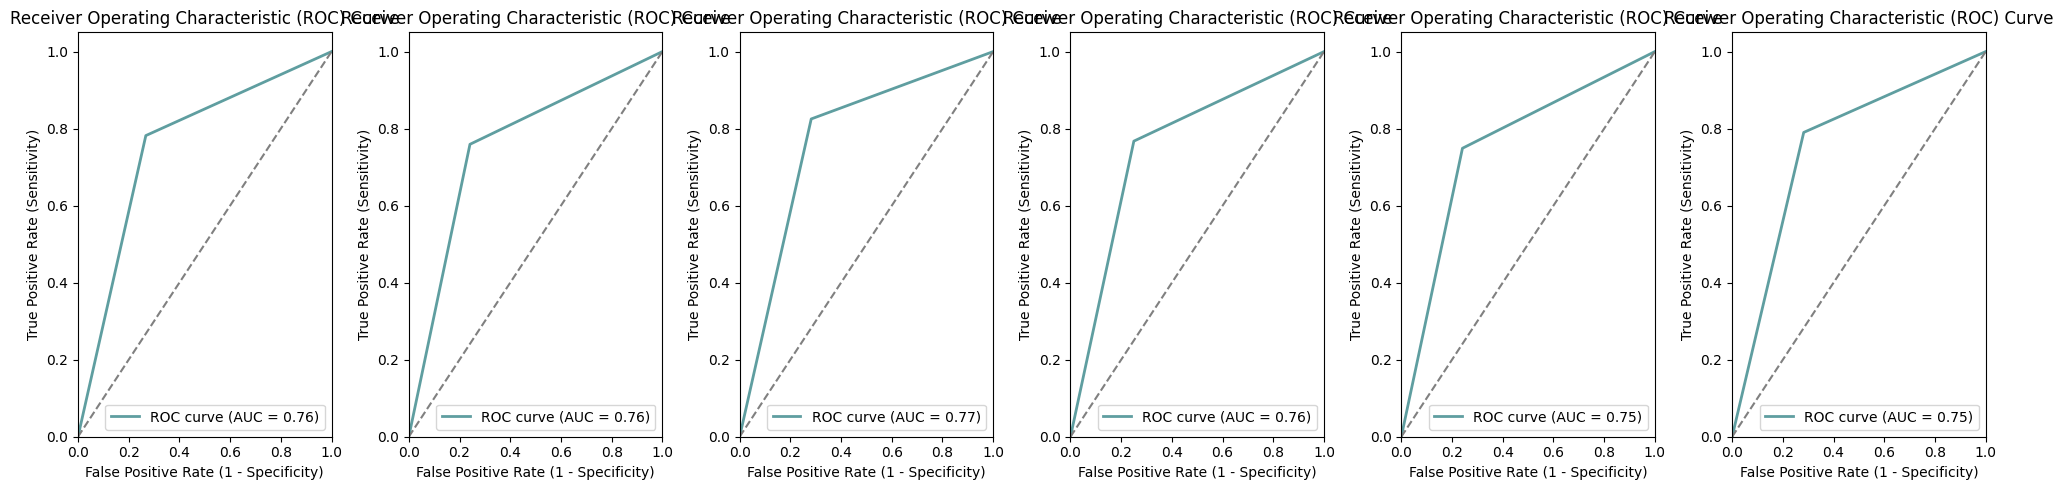

In [80]:
# ROC curve and AUC
prediction_results = [lr_predictions, svc_predictions, knn_predictions, ridge_predictions, gaussianNB_predicitons, mlp_predictions]
fig, axes = plt.subplots(1, len(prediction_results), figsize=(20, 5))

for i, result in enumerate(prediction_results):
    ax = axes[i]
    fpr, tpr, thresholds_roc = roc_curve(y, result)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    ax.plot(fpr, tpr, color='cadetblue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate (1 - Specificity)')
    ax.set_ylabel('True Positive Rate (Sensitivity)')
    ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

KNN Classifier seems to be the best candidate provinding the highest AUC. But is it overfitting ? Look at the learning curves plots below to find out.

#### Cross-Validation

In [81]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)

y_train_list = np.array(y_train)

candidates = [lr_model_tuned, svc_model_tuned, knn_model_tuned, ridge_model_tuned, naive_model_tuned, MLP_classifier_tuned]
mean_accuracies = []

for model in candidates:
    scores = []
    for train_idx, val_idx in rskf.split(X_train, y_train):  
        Xcross_train, ycross_train = X_train.iloc[train_idx], y_train_list[train_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train_list[val_idx]

        model.fit(Xcross_train, ycross_train)
        ycross_pred = model.predict(X_val)
        
        scores.append(accuracy_score(ycross_pred, y_val))
    
    # Mean score for each model after all folds
    print("Model : ", model)
    print("Scores:", scores)
    print("Mean =", np.mean(scores))
    mean_accuracies.append(np.mean(scores))

print("Models' mean accuracies after cross validation: ", mean_accuracies)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio p

Model :  LogisticRegression(C=0.1, l1_ratio=0.5, n_jobs=-1)
Scores: [0.7659574468085106, 0.7163120567375887, 0.75, 0.8214285714285714, 0.7571428571428571, 0.7588652482269503, 0.7801418439716312, 0.7714285714285715, 0.7428571428571429, 0.7428571428571429, 0.7446808510638298, 0.7801418439716312, 0.7571428571428571, 0.7571428571428571, 0.7642857142857142]
Mean = 0.7606923336710569
Model :  SVC(C=0.01, coef0=1.0, degree=2, kernel='linear', max_iter=300)
Scores: [0.7588652482269503, 0.7304964539007093, 0.75, 0.7928571428571428, 0.7642857142857142, 0.7588652482269503, 0.7872340425531915, 0.7642857142857142, 0.7142857142857143, 0.7428571428571429, 0.7446808510638298, 0.7588652482269503, 0.75, 0.7642857142857142, 0.7714285714285715]
Mean = 0.7568861870989531
Model :  KNeighborsClassifier(algorithm='brute', n_neighbors=7, p=1)
Scores: [0.7163120567375887, 0.7163120567375887, 0.7071428571428572, 0.7642857142857142, 0.7357142857142858, 0.7092198581560284, 0.7092198581560284, 0.6928571428571428, 0

Using cross validation the accuracy of logistic regression model is enhanced.

In [82]:
# a function to plot learning curves for our candidates
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=10)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
    plt.plot(train_sizes, valid_scores_mean, 'o-', label='Cross-validation score')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title(f'Learning Curve')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio p

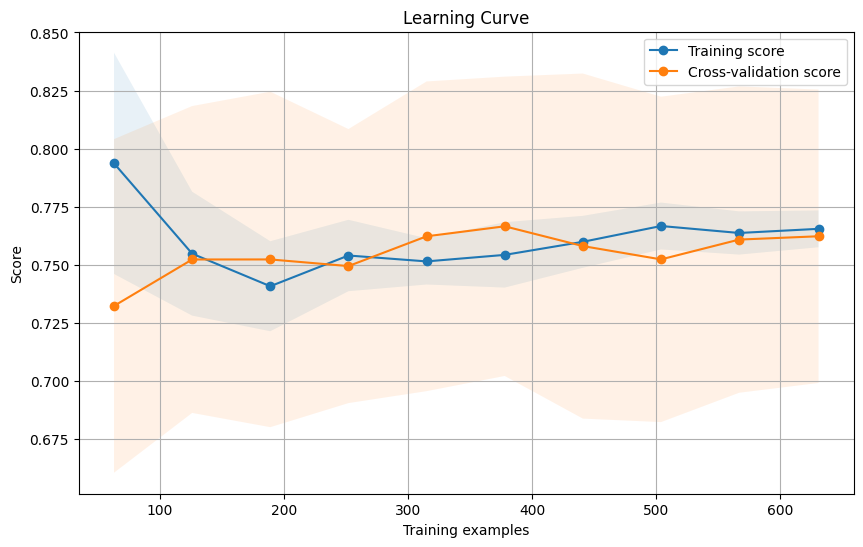

In [83]:
# Learning curve for tuned logistic regression model
plot_learning_curve(lr_model_tuned, X_train, y_train)

Tuned logistic regression model seems to be fitting data rapidly and in a good accuracy.

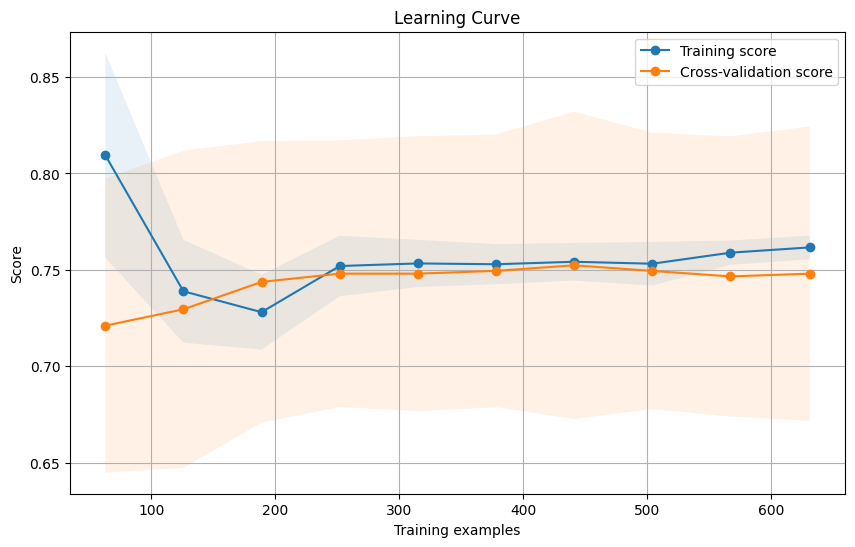

In [84]:
# Learning curve for tuned SVM classifier
plot_learning_curve(svc_model_tuned, X_train, y_train)

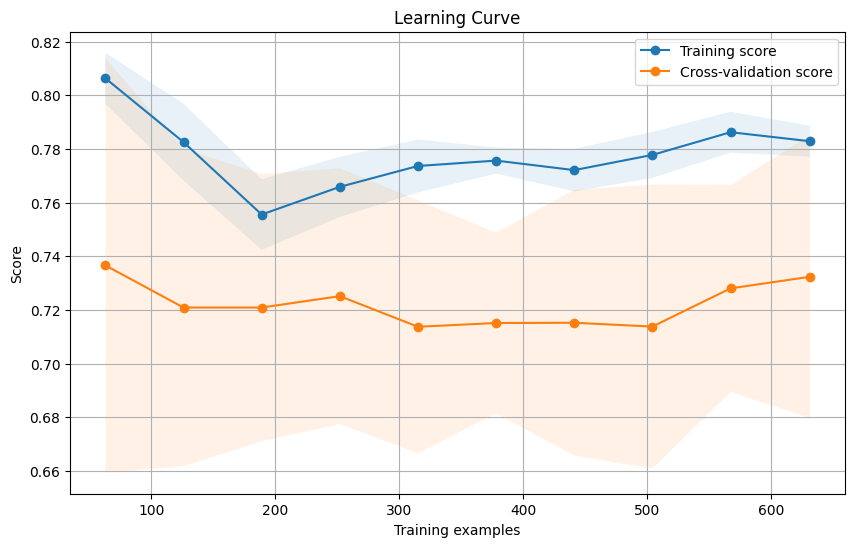

In [85]:
# Learning curve for KNN classifier
plot_learning_curve(knn_model_tuned, X_train, y_train)

KNN Classifier is overfitting !

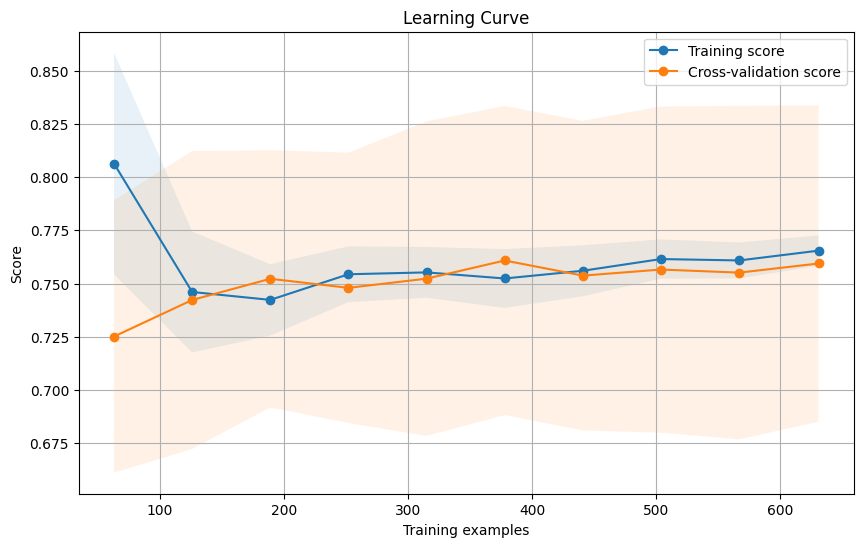

In [86]:
# Learning curve for tuned Ridge classifier
plot_learning_curve(ridge_model_tuned, X_train, y_train)

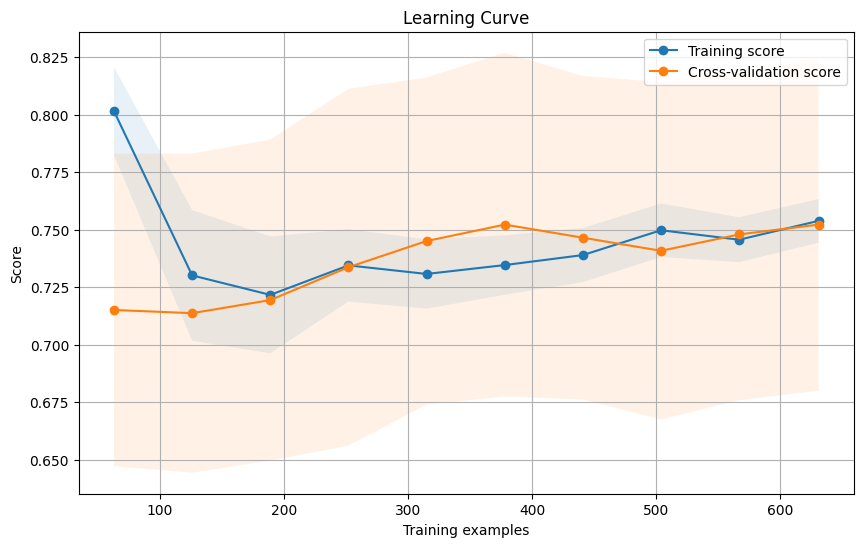

In [87]:
# Learning curve for tuned Gaussian Naive Bayes model
plot_learning_curve(naive_model_tuned, X_train, y_train)

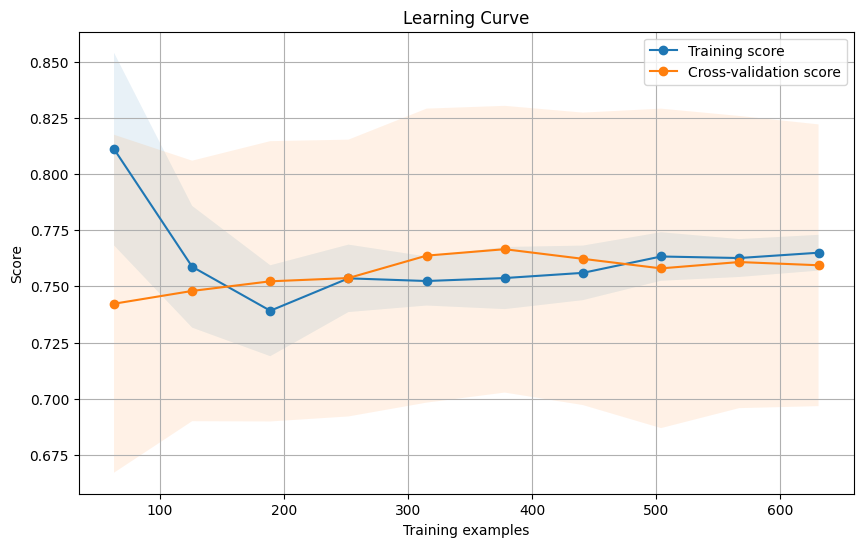

In [88]:
# Learning curve for tuned MLP Classifier
plot_learning_curve(MLP_classifier_tuned, X_train, y_train)

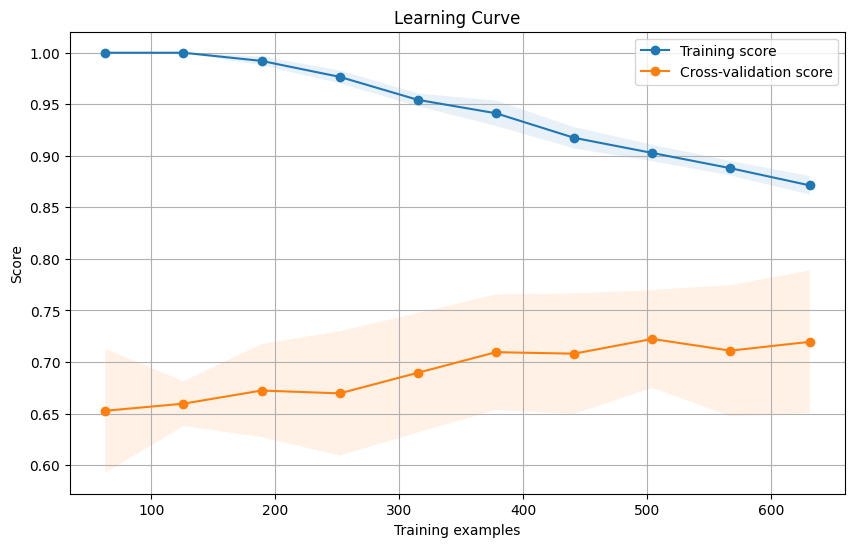

In [89]:
# Learning curve for Random Forest Model
plot_learning_curve(gradient_boosting_model, X_train, y_train)

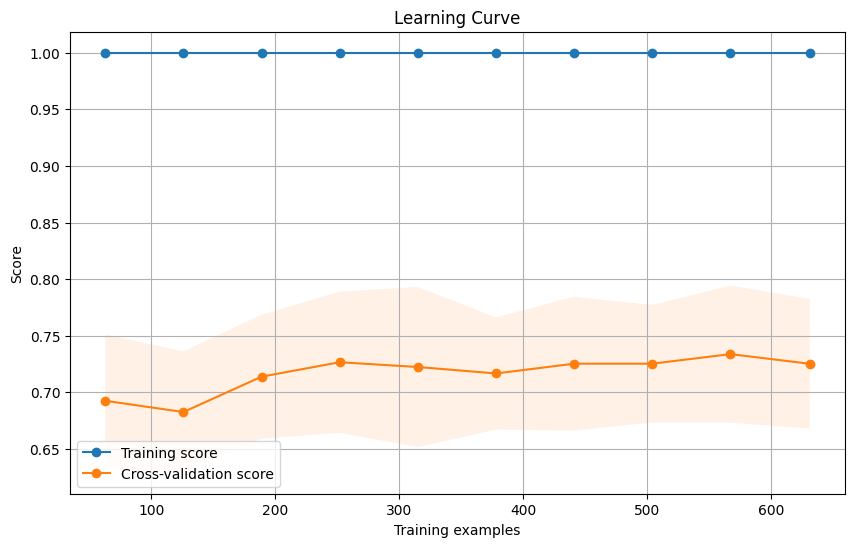

In [90]:
# Learning curve for Random Forest Model
plot_learning_curve(random_forest_model, X_train, y_train)

Logistic regression, SVM classifier, Ridge classifer, Gaussian Naive Bayes model and MLP classifier are candidates for our problem but Logistic regression, SVM classifier and MLP Classifier seem to be converging at better scores than the other models.

KNN classfier and other models like Decision trees and Random forest are clearly overfitting. I will be excluding them from this study.

#### A little bit more of tuning using Ensemble Methods

1. Bagging (Bootstrap Aggregating):

In [91]:
from sklearn.ensemble import BaggingClassifier

# Bagging with logistic_regression_model
bagging_lr = BaggingClassifier(base_estimator=lr_model_tuned, n_estimators=1000, random_state=0)
bagging_lr.fit(X_train, y_train)
y_bagging_lr = bagging_lr.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio 

In [92]:
print(accuracy_score(y_bagging_lr, y_test))
print(classification_report(y_bagging_lr, y_test))

0.75
              precision    recall  f1-score   support

           0       0.74      0.70      0.72        57
           1       0.76      0.79      0.77        67

    accuracy                           0.75       124
   macro avg       0.75      0.75      0.75       124
weighted avg       0.75      0.75      0.75       124



Not working in our favor, pass..

2. Boosting

In [93]:
from sklearn.ensemble import AdaBoostClassifier

# Boosting with logistic_regression_model
lr_adaboost = AdaBoostClassifier(base_estimator=lr_model_tuned, n_estimators=1000, random_state=0)
lr_adaboost.fit(X_train, y_train)
y_adaboost_lr = lr_adaboost.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio 

In [94]:
print(accuracy_score(y_adaboost_lr, y_test))
print(classification_report(y_adaboost_lr, y_test))

0.7419354838709677
              precision    recall  f1-score   support

           0       0.74      0.69      0.71        58
           1       0.74      0.79      0.76        66

    accuracy                           0.74       124
   macro avg       0.74      0.74      0.74       124
weighted avg       0.74      0.74      0.74       124



Same, pass..

3. Stacking

In [95]:
from sklearn.ensemble import StackingClassifier

base_estimators = [
    ('logistic_regression', lr_model_tuned),
    ('MLP CLassifier', MLP_classifier_tuned)
]

# first we define a meta-estimator
meta_estimator = LogisticRegression(random_state=0)

stacking = StackingClassifier(estimators=base_estimators, final_estimator=meta_estimator)

stacking.fit(X_train, y_train)
y_stacking = stacking.predict(X_test)

stacking_accuracy = accuracy_score(y_stacking, y_test)

stacking_accuracy

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning:

l1_ratio p

0.7580645161290323

In [96]:
lr_mlp_stacking_pred= stacking.predict(X_test)

In [97]:
print("Training accuracy =", accuracy_score(y_test, lr_mlp_stacking_pred))
print(classification_report(y_test, lr_mlp_stacking_pred))

Training accuracy = 0.7580645161290323
              precision    recall  f1-score   support

           0       0.71      0.74      0.73        54
           1       0.79      0.77      0.78        70

    accuracy                           0.76       124
   macro avg       0.75      0.76      0.75       124
weighted avg       0.76      0.76      0.76       124



Our logistic regression model seems to be enhanced when stacking it with MLP Classifier. Although, its performance on predicting unknown traffic (0) is not as high as predicting high traffic.

And it's generalizing better than it was :

In [98]:
lr_mlp_stacking_gen = stacking.predict(X_scaled)
print("Generalization accuracy =", accuracy_score(y, lr_mlp_stacking_gen))
print(classification_report(y, lr_mlp_stacking_gen))

Generalization accuracy = 0.7627118644067796
              precision    recall  f1-score   support

           0       0.71      0.72      0.71       340
           1       0.80      0.79      0.80       486

    accuracy                           0.76       826
   macro avg       0.76      0.76      0.76       826
weighted avg       0.76      0.76      0.76       826



### <span style="color:green"><b> Getting Business results</b></span>

In [99]:
predictions_df = df_zscore_encoded.copy()
# predictions_df['LR_results'] = lr_predictions
# predictions_df['MLP_results'] = mlp_predictions
predictions_df['category_encoded'] = label_encoder.inverse_transform(predictions_df['category_encoded'])
predictions_df.rename(columns={'category_encoded': 'category'}, inplace=True)
predictions_df.rename(columns={'traffic_encoded': 'high_traffic'}, inplace=True)
predictions_df['predictions'] = lr_mlp_stacking_gen
predictions_df['high_traffic'].replace({1:'High', 0:'Unknown'}, inplace=True)
predictions_df['predictions'].replace({1:'High', 0:'Unknown'}, inplace=True)
predictions_df

,recipe,calories,carbohydrate,sugar,protein,servings,category,high_traffic,predictions
1,2,35.48,38.56,0.66,0.92,4,Potato,High,High
2,3,914.28,42.68,3.09,2.88,1,Breakfast,Unknown,Unknown
3,4,97.03,30.56,38.63,0.02,4,Beverages,High,Unknown
4,5,27.05,1.85,0.80,0.53,4,Beverages,Unknown,Unknown
5,6,691.15,3.46,1.65,53.93,2,One Dish Meal,High,High
...,...,...,...,...,...,...,...,...,...
941,942,186.21,83.94,1.98,22.40,4,Chicken,High,Unknown
942,943,1161.00,5.31,22.39,44.22,2,Lunch/Snacks,Unknown,High
944,945,951.74,29.42,3.57,13.87,2,Pork,High,High
945,946,266.61,35.77,0.97,8.07,6,Potato,High,High


As already noticed, our model is not that good predicting unknown traffic but it have a good performance predicting High traffic so let's focus on that.

In [100]:
high_traffic_df = predictions_df[predictions_df['predictions'] == 'High']
high_traffic_df.sample(20)

,recipe,calories,carbohydrate,sugar,protein,servings,category,high_traffic,predictions
802,803,71.73,25.82,2.41,33.21,6,Meat,Unknown,High
903,904,284.59,9.73,1.76,111.57,4,Meat,High,High
186,187,515.49,5.88,13.29,13.96,1,Lunch/Snacks,High,High
191,192,646.15,22.10,39.34,16.73,6,Dessert,Unknown,High
301,302,293.86,11.43,3.16,0.98,2,Vegetable,High,High
475,476,54.97,3.72,7.26,1.08,4,Vegetable,High,High
336,337,857.34,67.38,4.97,2.80,4,Dessert,Unknown,High
324,325,771.52,96.03,1.49,7.52,4,Dessert,High,High
710,711,207.57,1.52,4.46,15.05,6,One Dish Meal,High,High
234,235,627.16,34.96,41.50,16.15,6,Dessert,Unknown,High


And now we select High traffic predictions for previously unknwon traffic

In [101]:
high_traffic_recipe_df = high_traffic_df[high_traffic_df['high_traffic'] == 'Unknown']
high_traffic_recipe_df

,recipe,calories,carbohydrate,sugar,protein,servings,category,high_traffic,predictions
7,8,299.14,3.17,0.40,32.40,4,Lunch/Snacks,Unknown,High
35,36,796.89,29.10,9.63,2.28,2,Lunch/Snacks,Unknown,High
42,43,576.89,4.79,20.92,4.29,2,One Dish Meal,Unknown,High
50,51,293.36,19.16,9.40,1.32,2,Pork,Unknown,High
61,62,187.87,55.51,9.99,86.09,4,One Dish Meal,Unknown,High
...,...,...,...,...,...,...,...,...,...
894,895,576.07,21.89,2.96,71.16,4,Pork,Unknown,High
897,898,576.38,15.98,0.54,36.23,2,Pork,Unknown,High
906,907,194.37,12.17,1.58,3.67,4,Lunch/Snacks,Unknown,High
932,933,1017.32,85.12,1.71,1.85,1,Potato,Unknown,High


And these are the recommended recipes to feature on the platform, alongside the popular recipes with high traffic.

In [102]:
false_pred = predictions_df[(predictions_df['high_traffic'] == 'High') & (predictions_df['predictions'] == 'Unknown')]
false_pred

,recipe,calories,carbohydrate,sugar,protein,servings,category,high_traffic,predictions
3,4,97.03,30.56,38.63,0.02,4,Beverages,High,Unknown
24,25,1161.49,1.53,8.88,12.57,1,Breakfast,High,Unknown
34,35,575.63,20.71,0.20,6.24,6,Breakfast,High,Unknown
40,41,621.54,14.16,10.70,39.69,6,Chicken,High,Unknown
49,50,1724.25,45.52,0.07,49.37,1,Breakfast,High,Unknown
...,...,...,...,...,...,...,...,...,...
887,888,1716.03,19.99,6.71,25.29,2,Chicken,High,Unknown
901,902,92.61,1.35,3.59,0.04,6,Beverages,High,Unknown
920,921,375.32,131.80,16.43,4.76,4,Chicken,High,Unknown
933,934,47.74,5.33,0.87,17.42,4,Chicken,High,Unknown


I highly recommend the team to get more data and work on the quality of stored data because many observations with high traffic were predicted not to lead to high traffic and missing data and outliers affect the study and make our results less reliable in the futur.